In [1]:
from ObservationData import ObservationData, Corrector
from astropy.time import Time
from astropy.io import fits
import astroalign as aa
from tqdm import tqdm
import os


data_manager = ObservationData("/net/virgo01/data/users/tboersma/2025-04-30/")

end_jd = Time("2025-04-30 23:30").jd
data_manager.directory_frame.sort_values(by="JD", inplace=True)
print(data_manager.directory_frame)
data_manager.save_csv("raw_files.csv")
data_manager.filter(f"JD <= {end_jd}", replace=True)
data_manager.save_csv("file_data.csv")


                            FILENAME       OBJECT   FILTER     IMAGETYP  \
185                 master_bias.fits  LDST_250430     None  MASTER_BIAS   
423        LDST_250430-0001_Bias.fit  LDST_250430     None         BIAS   
130        LDST_250430-0002_Bias.fit  LDST_250430     None         BIAS   
240        LDST_250430-0003_Bias.fit  LDST_250430     None         BIAS   
153        LDST_250430-0004_Bias.fit  LDST_250430     None         BIAS   
..                               ...          ...      ...          ...   
100  LDST_250430-0003_Halphaflat.fit  LDST_250430  H_alpha         FLAT   
118  LDST_250430-0004_Halphaflat.fit  LDST_250430  H_alpha         FLAT   
455  LDST_250430-0005_Halphaflat.fit  LDST_250430  H_alpha         FLAT   
114        LDST_250430-0015_dark.fit  LDST_250430    ND1.2        LIGHT   
410        LDST_250430-0016_dark.fit  LDST_250430    ND1.2        LIGHT   

                   DATE-OBS EXP-TIME            JD  
185  2025-04-30T18:22:10.41     None  2.460796

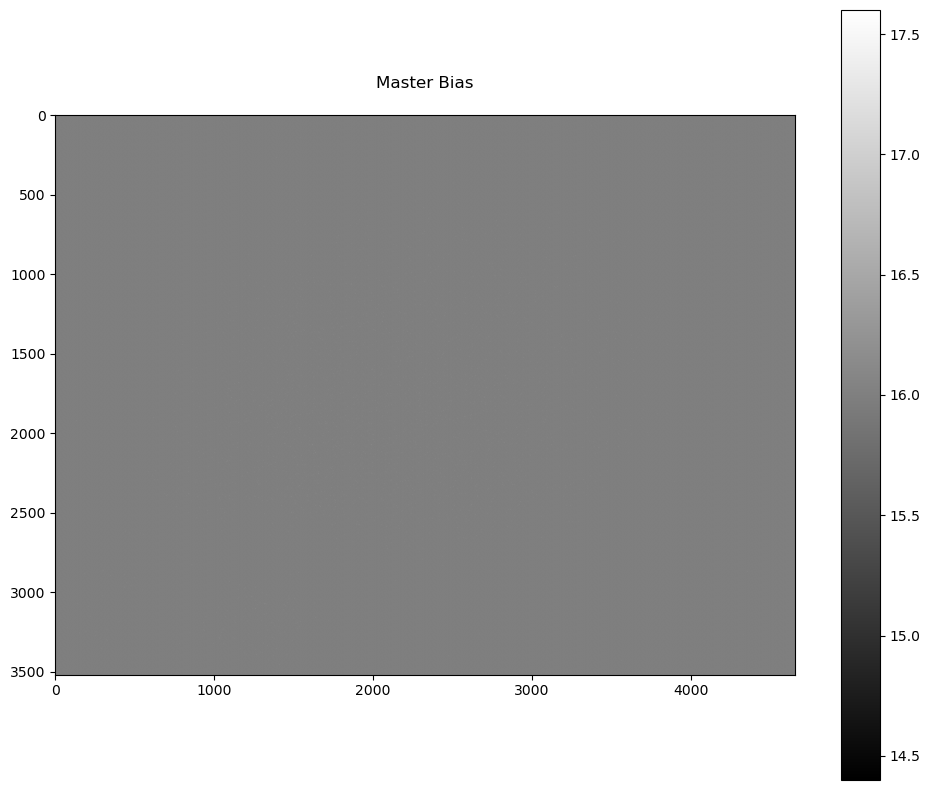

In [2]:
# Compute Master Bias
import numpy as np

data_manager.load_csv('file_data.csv')
bias_files = data_manager.filter(f"IMAGETYP == 'BIAS'", replace=False)["FILENAME"].tolist()

bias_data = data_manager.load_data(f"IMAGETYP == 'BIAS'")
master_bias = np.median(bias_data, axis=-1)

header = fits.getheader(os.path.join(data_manager.directory_path, bias_files[0]))
header['IMAGETYP'] = 'MASTER_BIAS'
header['NFRAMES'] = len(bias_data)
header['COMBINED'] = 'MEDIAN'
header['COMMENT'] = 'Master bias frame created from raw bias exposures'

fits.writeto(os.path.join(data_manager.directory_path, 'master_bias.fits'), master_bias, header, overwrite=True)
data_manager.add_file('master_bias.fits')

data_manager.plot_gray_scale(master_bias, "Master Bias")
data_manager.save_csv('file_data.csv')


{'H_alpha', 'ND1.2', 'B*', 'G*', 'R*', 'Lum'}


  0%|          | 0/6 [00:00<?, ?it/s]

H_alpha


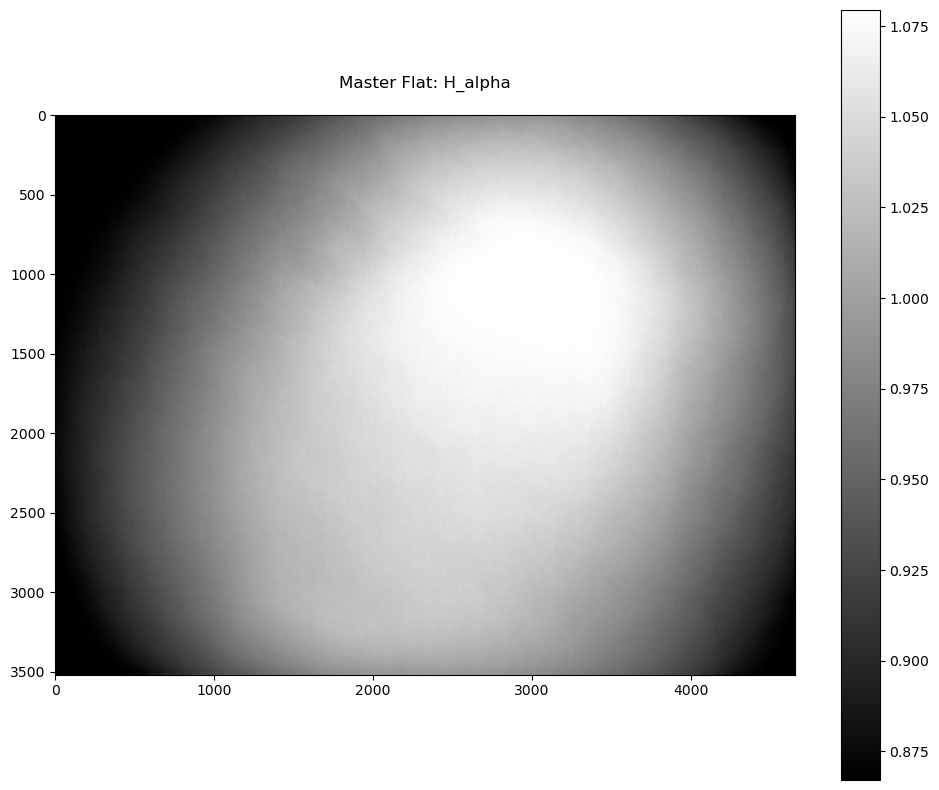

 17%|█▋        | 1/6 [00:06<00:30,  6.15s/it]

B*


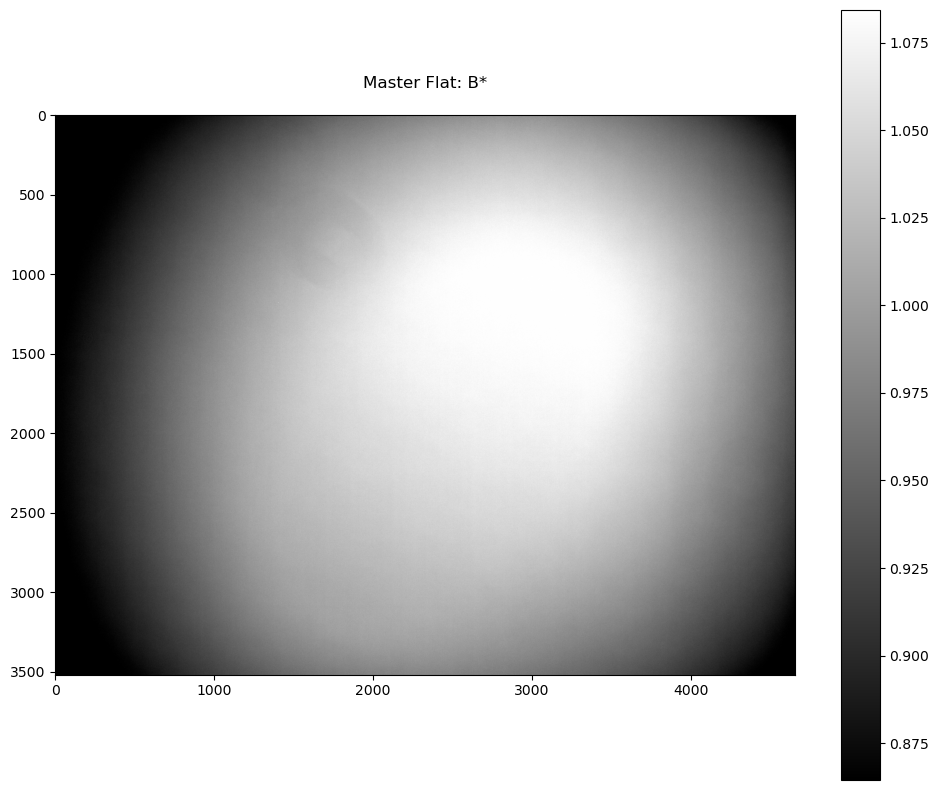

 50%|█████     | 3/6 [00:11<00:10,  3.52s/it]

G*


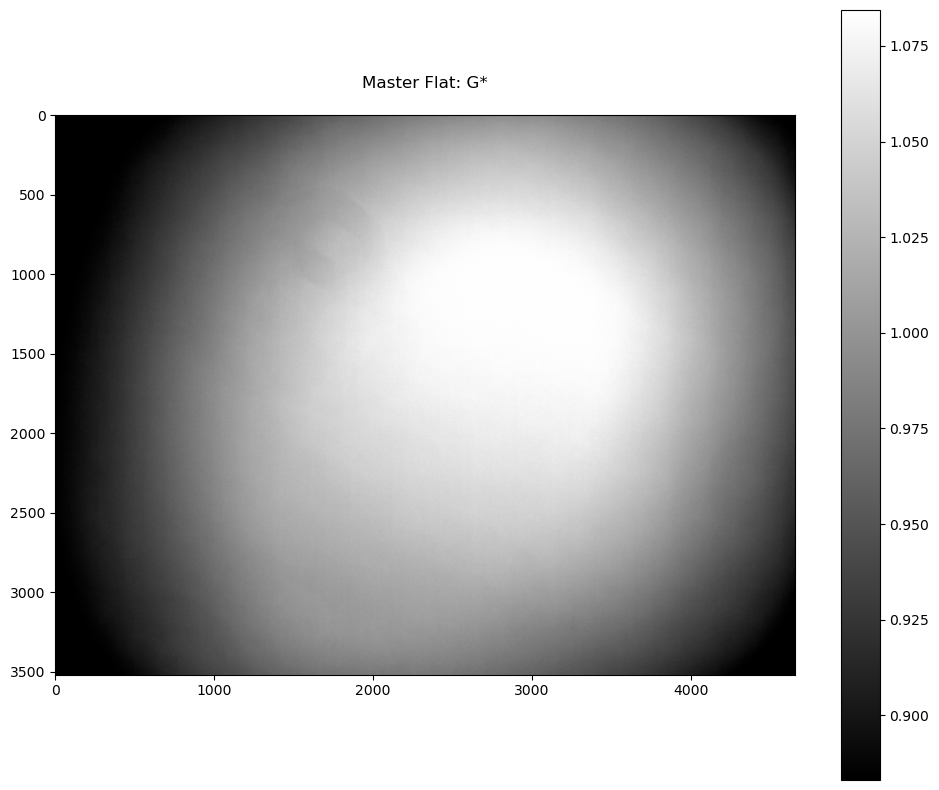

 67%|██████▋   | 4/6 [00:16<00:08,  4.09s/it]

R*


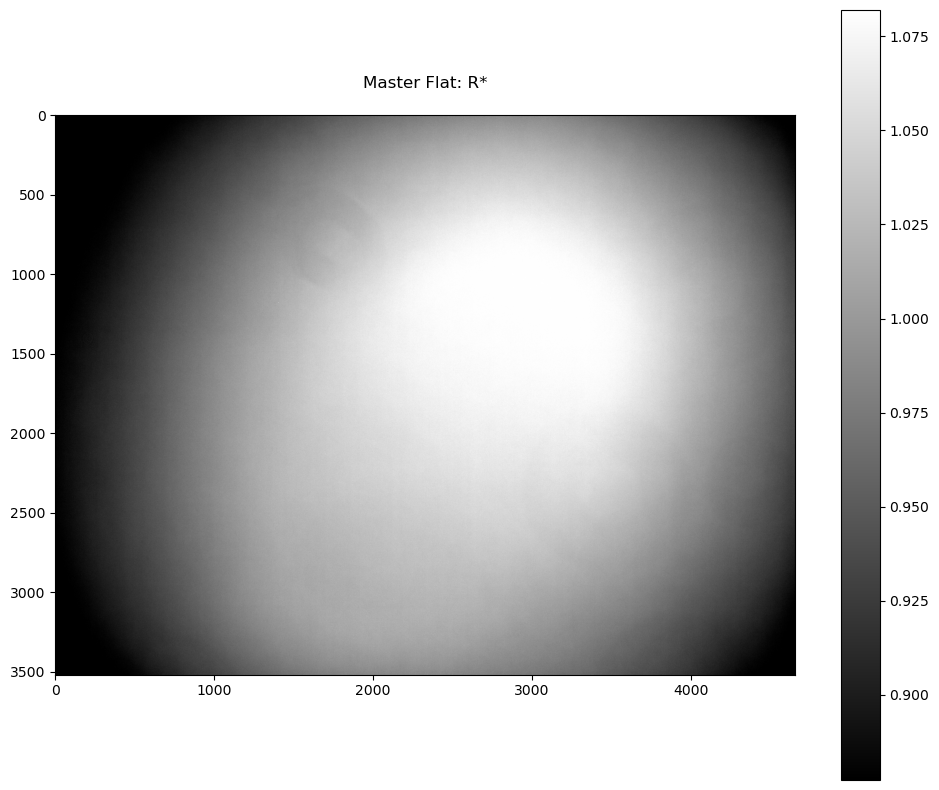

 83%|████████▎ | 5/6 [00:21<00:04,  4.50s/it]

Lum


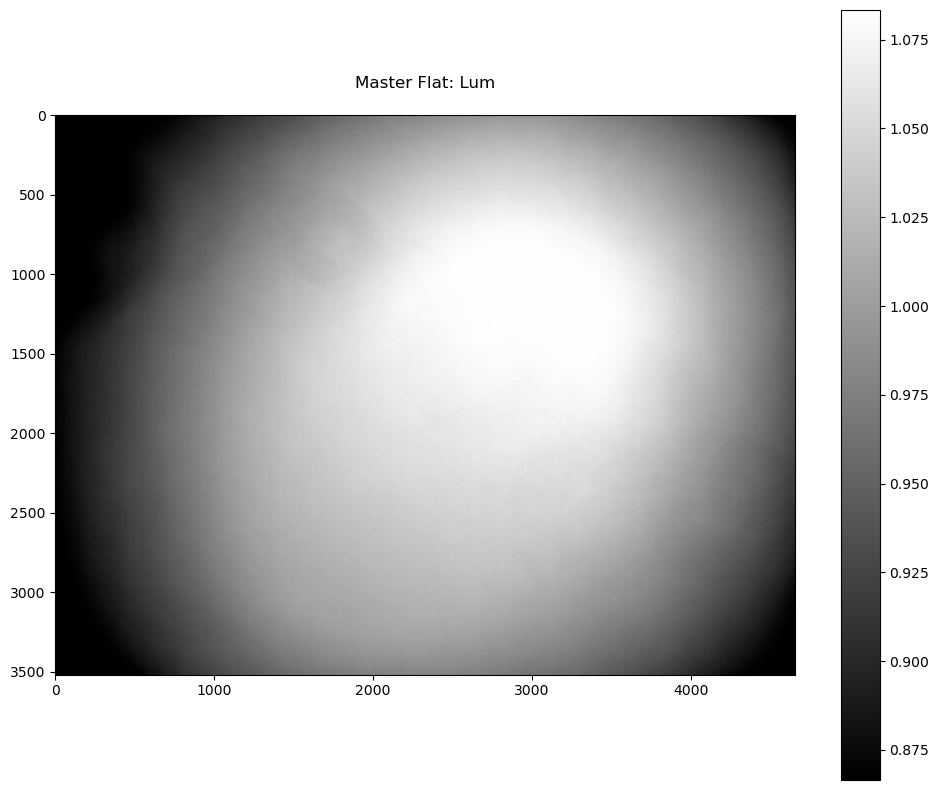

100%|██████████| 6/6 [00:27<00:00,  4.51s/it]


In [3]:
# Compute Master FLATS
import numpy as np

data_manager.load_csv('file_data.csv')
flat_files = data_manager.filter("IMAGETYP == 'FLAT'", replace=False)
master_bias = fits.getdata(os.path.join(data_manager.directory_path, 'master_bias.fits'))


filters = set(data_manager.directory_frame["FILTER"].dropna())
print(filters)
flat_dict = {}

header = fits.getheader(os.path.join(data_manager.directory_path, flat_files['FILENAME'].tolist()[0]))
header['IMAGETYP'] = 'MASTER_BIAS'

header['COMBINED'] = 'MEDIAN'
header['COMMENT'] = 'Master bias frame created from normalized flat exposures'


for fil in tqdm(filters):
    if fil is None or fil == float('nan') or fil == "ND1.2":
        continue
    
    print(fil)
    
    flat_data = data_manager.load_data(f"IMAGETYP == 'FLAT' & FILTER == '{fil}'")
    normalized_data = (flat_data - master_bias[..., np.newaxis]) / np.median(flat_data, axis=(0,1))  
        
    flat_dict[fil] = np.median(normalized_data, axis=-1)

    header['NFRAMES'] = len(flat_data)
    header['FILTER'] = fil 
    
    data_manager.plot_gray_scale(flat_dict[fil], f"Master Flat: {fil}")
    
    fits.writeto(os.path.join(data_manager.directory_path, f'master_flat_{fil}.fits'), master_bias, header, overwrite=True)
    data_manager.add_file(f'master_flat_{fil}.fits')
data_manager.save_csv('file_data.csv')


In [4]:
import matplotlib.pyplot as plt

data_corrector = Corrector(master_bias, flat_dict)

img_files = data_manager.filter("IMAGETYP == 'LIGHT' & FILTER != 'ND1.2' & FILTER != 'None'")

for idx, row in tqdm(img_files.iterrows()):
    fp = row["FILENAME"]
    name = fp.split('_')[-1][:-4]
    
    data = fits.getdata(os.path.join(data_manager.directory_path, fp))
    
    fil = row["FILTER"]
    
    corrected = data_corrector.correct(data, fil)
    
    
    obj = "STARFIELD" if "star" in fp else "M82"
    
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    header['COMMENT'] = 'Reduced frame created from master_bias and master_flat'
    header['IMAGETYP'] = 'REDUCED'
    header['OBJECT'] = obj
    
    file_name = f'reduced_{obj}_{fil}_{idx}.fits'
    
    fits.writeto(os.path.join(data_manager.directory_path, file_name), corrected, header, overwrite=True)
    data_manager.add_file(file_name)
data_manager.save_csv('file_data.csv')

128it [00:54,  2.35it/s]


In [5]:

reduced_files = data_manager.filter("IMAGETYP == 'REDUCED'")

targets = {}
data_manager.load_csv('file_data.csv')

for idx, row in tqdm(reduced_files.iterrows()):
    fp = row["FILENAME"]

    
    data = fits.getdata(os.path.join(data_manager.directory_path, fp))
    data = data.byteswap().newbyteorder()
    
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    key = f"{header['OBJECT']}_{header['FILTER']}"
    
    if key not in targets.keys():
        targets[key] = data
        continue
    
    ref_data = targets[key].byteswap().newbyteorder()  
    try:
        registered, _ = aa.register(data, ref_data)
    except aa.MaxIterError:
        print(f"No fit found for {header['OBJECT']} {header['FILTER']} idx={idx} at {fp}")
        continue
   
    header = fits.getheader(os.path.join(data_manager.directory_path, fp))
    header['COMMENT'] = 'Registered frame created from master_bias and master_flat'
    header['IMAGETYP'] = 'REGISTERED'
    fits.writeto(os.path.join(data_manager.directory_path, f'registered_{key}_{idx}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'registered_{key}_{idx}.fits')
    
    
data_manager.save_csv('file_data.csv')


45it [02:20,  2.82s/it]

No fit found for M82 R* idx=183 at reduced_M82_R*_90.fits


47it [02:25,  2.67s/it]

No fit found for M82 B* idx=186 at reduced_M82_B*_92.fits


48it [02:27,  2.56s/it]

No fit found for M82 H_alpha idx=189 at reduced_M82_H_alpha_93.fits


49it [02:30,  2.68s/it]

No fit found for M82 R* idx=190 at reduced_M82_R*_94.fits


50it [02:34,  2.88s/it]

No fit found for M82 G* idx=193 at reduced_M82_G*_95.fits


51it [02:36,  2.78s/it]

No fit found for M82 B* idx=194 at reduced_M82_B*_96.fits


54it [02:44,  2.72s/it]

No fit found for M82 G* idx=200 at reduced_M82_G*_99.fits


55it [02:47,  2.62s/it]

No fit found for M82 B* idx=203 at reduced_M82_B*_100.fits


56it [02:49,  2.57s/it]

No fit found for M82 H_alpha idx=204 at reduced_M82_H_alpha_101.fits


57it [02:52,  2.53s/it]

No fit found for M82 R* idx=206 at reduced_M82_R*_102.fits


60it [02:59,  2.44s/it]

No fit found for M82 H_alpha idx=212 at reduced_M82_H_alpha_105.fits


61it [03:02,  2.56s/it]

No fit found for M82 R* idx=215 at reduced_M82_R*_106.fits


62it [03:04,  2.61s/it]

No fit found for M82 G* idx=216 at reduced_M82_G*_107.fits


63it [03:07,  2.56s/it]

No fit found for M82 B* idx=218 at reduced_M82_B*_108.fits


64it [03:10,  2.70s/it]

No fit found for M82 H_alpha idx=221 at reduced_M82_H_alpha_109.fits


66it [03:15,  2.77s/it]

No fit found for M82 G* idx=224 at reduced_M82_G*_111.fits


67it [03:18,  2.79s/it]

No fit found for M82 B* idx=227 at reduced_M82_B*_112.fits


68it [03:21,  2.85s/it]

No fit found for M82 H_alpha idx=229 at reduced_M82_H_alpha_113.fits


69it [03:24,  2.82s/it]

No fit found for M82 R* idx=230 at reduced_M82_R*_114.fits


70it [03:27,  2.80s/it]

No fit found for M82 G* idx=233 at reduced_M82_G*_115.fits


71it [03:29,  2.78s/it]

No fit found for M82 B* idx=235 at reduced_M82_B*_116.fits


72it [03:32,  2.62s/it]

No fit found for M82 H_alpha idx=237 at reduced_M82_H_alpha_117.fits


73it [03:34,  2.66s/it]

No fit found for M82 R* idx=238 at reduced_M82_R*_118.fits


74it [03:37,  2.68s/it]

No fit found for M82 G* idx=241 at reduced_M82_G*_119.fits


75it [03:40,  2.64s/it]

No fit found for M82 B* idx=242 at reduced_M82_B*_120.fits


76it [03:43,  2.83s/it]

No fit found for M82 H_alpha idx=245 at reduced_M82_H_alpha_121.fits


77it [03:46,  2.84s/it]

No fit found for M82 R* idx=247 at reduced_M82_R*_122.fits


78it [03:49,  2.83s/it]

No fit found for M82 G* idx=248 at reduced_M82_G*_123.fits


79it [03:51,  2.74s/it]

No fit found for M82 B* idx=250 at reduced_M82_B*_124.fits


80it [03:53,  2.57s/it]

No fit found for M82 H_alpha idx=252 at reduced_M82_H_alpha_125.fits


81it [03:56,  2.58s/it]

No fit found for M82 R* idx=255 at reduced_M82_R*_126.fits


82it [03:58,  2.54s/it]

No fit found for M82 G* idx=257 at reduced_M82_G*_127.fits


83it [04:01,  2.49s/it]

No fit found for M82 B* idx=259 at reduced_M82_B*_128.fits


84it [04:03,  2.40s/it]

No fit found for M82 H_alpha idx=260 at reduced_M82_H_alpha_129.fits


85it [04:06,  2.50s/it]

No fit found for M82 R* idx=263 at reduced_M82_R*_130.fits


86it [04:09,  2.70s/it]

No fit found for M82 G* idx=265 at reduced_M82_G*_131.fits


87it [04:11,  2.59s/it]

No fit found for M82 B* idx=266 at reduced_M82_B*_132.fits


88it [04:13,  2.41s/it]

No fit found for M82 H_alpha idx=268 at reduced_M82_H_alpha_133.fits


173it [09:36,  2.84s/it]

No fit found for M82 R* idx=440 at reduced_M82_R*_182.fits


174it [09:38,  2.75s/it]

No fit found for M82 G* idx=441 at reduced_M82_G*_184.fits


175it [09:40,  2.59s/it]

No fit found for M82 B* idx=442 at reduced_M82_B*_187.fits


176it [09:43,  2.55s/it]

No fit found for M82 H_alpha idx=443 at reduced_M82_H_alpha_188.fits


177it [09:45,  2.46s/it]

No fit found for M82 R* idx=444 at reduced_M82_R*_191.fits


178it [09:48,  2.43s/it]

No fit found for M82 G* idx=445 at reduced_M82_G*_192.fits


179it [09:50,  2.37s/it]

No fit found for M82 B* idx=446 at reduced_M82_B*_195.fits


180it [09:52,  2.38s/it]

No fit found for M82 H_alpha idx=447 at reduced_M82_H_alpha_197.fits


181it [09:55,  2.44s/it]

No fit found for M82 R* idx=448 at reduced_M82_R*_198.fits


182it [09:57,  2.50s/it]

No fit found for M82 G* idx=449 at reduced_M82_G*_201.fits


183it [09:59,  2.36s/it]

No fit found for M82 B* idx=450 at reduced_M82_B*_202.fits


184it [10:02,  2.33s/it]

No fit found for M82 H_alpha idx=451 at reduced_M82_H_alpha_205.fits


185it [10:04,  2.35s/it]

No fit found for M82 R* idx=452 at reduced_M82_R*_207.fits


186it [10:07,  2.43s/it]

No fit found for M82 G* idx=453 at reduced_M82_G*_209.fits


187it [10:09,  2.41s/it]

No fit found for M82 B* idx=454 at reduced_M82_B*_210.fits


188it [10:12,  2.62s/it]

No fit found for M82 H_alpha idx=455 at reduced_M82_H_alpha_213.fits


189it [10:15,  2.59s/it]

No fit found for M82 R* idx=456 at reduced_M82_R*_214.fits


190it [10:17,  2.59s/it]

No fit found for M82 G* idx=457 at reduced_M82_G*_217.fits


191it [10:20,  2.50s/it]

No fit found for M82 B* idx=458 at reduced_M82_B*_219.fits


192it [10:22,  2.37s/it]

No fit found for M82 H_alpha idx=459 at reduced_M82_H_alpha_220.fits


193it [10:24,  2.37s/it]

No fit found for M82 R* idx=460 at reduced_M82_R*_223.fits


194it [10:26,  2.35s/it]

No fit found for M82 G* idx=461 at reduced_M82_G*_225.fits


195it [10:29,  2.59s/it]

No fit found for M82 B* idx=462 at reduced_M82_B*_226.fits


196it [10:32,  2.46s/it]

No fit found for M82 H_alpha idx=463 at reduced_M82_H_alpha_228.fits


197it [10:34,  2.47s/it]

No fit found for M82 R* idx=464 at reduced_M82_R*_231.fits


198it [10:36,  2.45s/it]

No fit found for M82 G* idx=465 at reduced_M82_G*_232.fits


199it [10:39,  2.37s/it]

No fit found for M82 B* idx=466 at reduced_M82_B*_234.fits


200it [10:41,  2.26s/it]

No fit found for M82 H_alpha idx=467 at reduced_M82_H_alpha_236.fits


201it [10:43,  2.32s/it]

No fit found for M82 R* idx=468 at reduced_M82_R*_239.fits


202it [10:45,  2.32s/it]

No fit found for M82 G* idx=469 at reduced_M82_G*_240.fits


203it [10:48,  2.29s/it]

No fit found for M82 B* idx=470 at reduced_M82_B*_243.fits


204it [10:50,  2.18s/it]

No fit found for M82 H_alpha idx=471 at reduced_M82_H_alpha_244.fits


205it [10:52,  2.24s/it]

No fit found for M82 R* idx=472 at reduced_M82_R*_246.fits


206it [10:54,  2.30s/it]

No fit found for M82 G* idx=473 at reduced_M82_G*_249.fits


207it [10:57,  2.27s/it]

No fit found for M82 B* idx=474 at reduced_M82_B*_251.fits


208it [11:00,  2.49s/it]

No fit found for M82 H_alpha idx=475 at reduced_M82_H_alpha_253.fits


209it [11:02,  2.50s/it]

No fit found for M82 R* idx=476 at reduced_M82_R*_254.fits


210it [11:06,  2.78s/it]

No fit found for M82 G* idx=477 at reduced_M82_G*_256.fits


211it [11:09,  2.93s/it]

No fit found for M82 B* idx=478 at reduced_M82_B*_258.fits


212it [11:11,  2.75s/it]

No fit found for M82 H_alpha idx=479 at reduced_M82_H_alpha_261.fits


213it [11:14,  2.82s/it]

No fit found for M82 R* idx=480 at reduced_M82_R*_262.fits


214it [11:18,  3.19s/it]

No fit found for M82 G* idx=481 at reduced_M82_G*_264.fits


215it [11:20,  2.87s/it]

No fit found for M82 B* idx=482 at reduced_M82_B*_267.fits


216it [11:22,  2.60s/it]

No fit found for M82 H_alpha idx=483 at reduced_M82_H_alpha_269.fits


256it [13:44,  3.22s/it]


{'M82'}


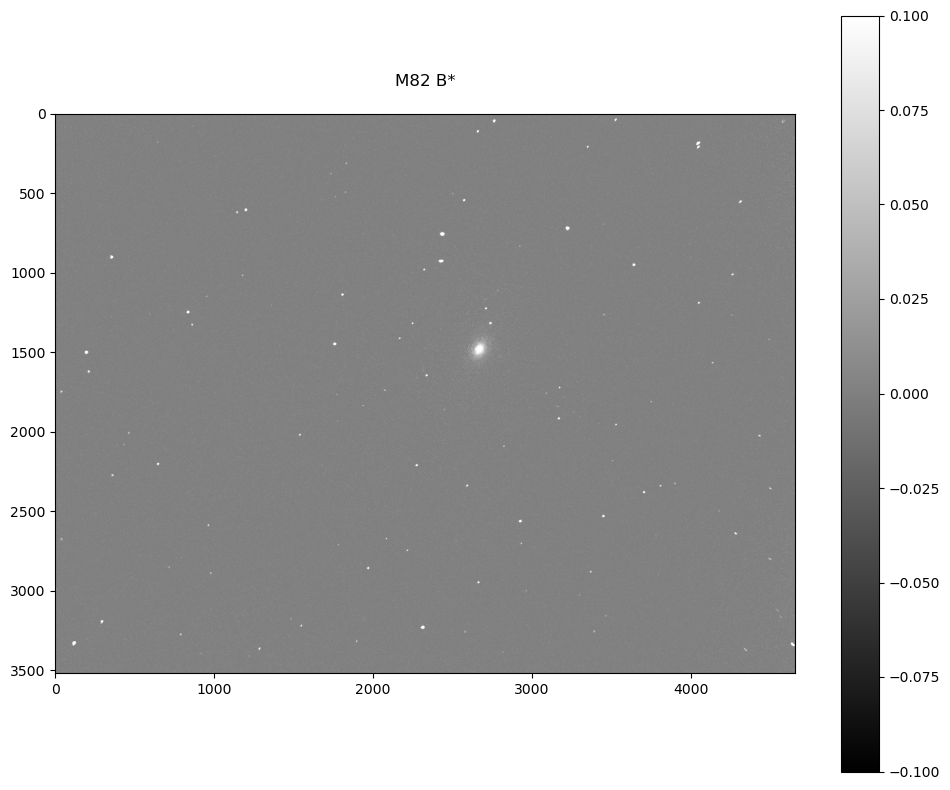

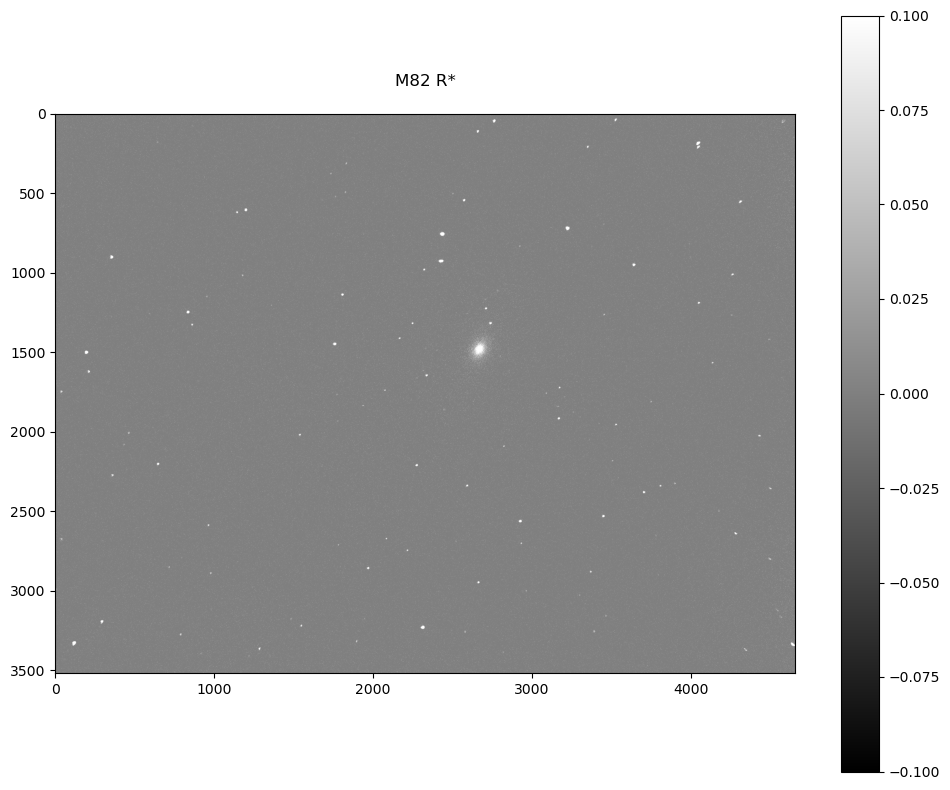

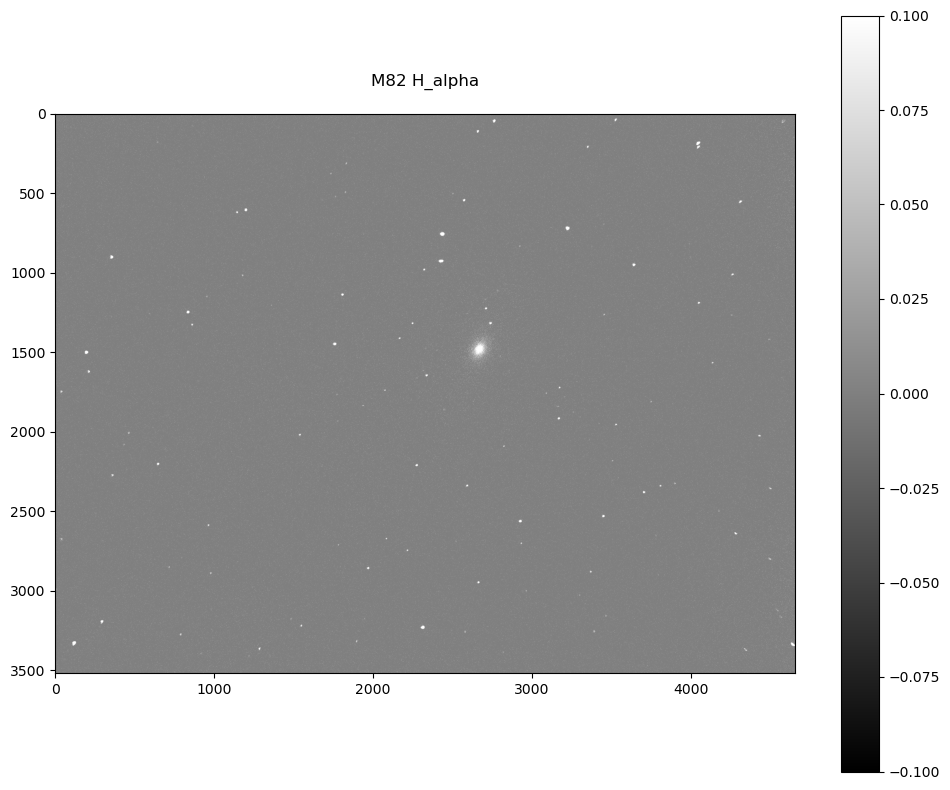

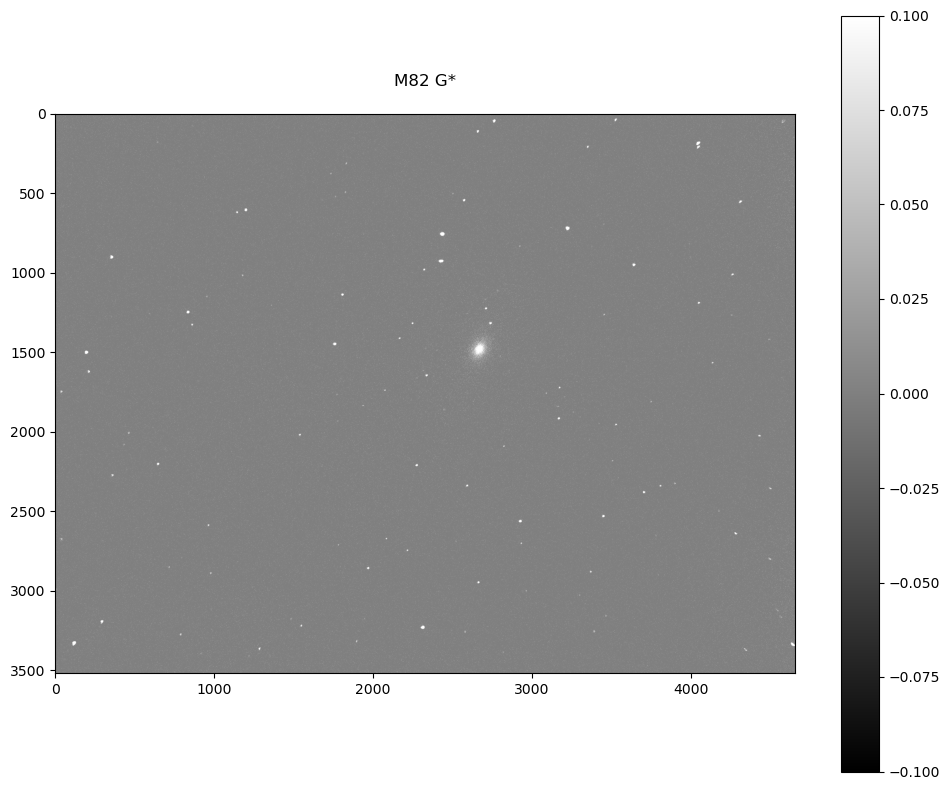

In [6]:
from itertools import product

data_manager.load_csv('file_data.csv')
registered_files = data_manager.filter("IMAGETYP == 'REGISTERED'")
file = registered_files['FILENAME'].tolist()[0]
header = fits.getheader(os.path.join(data_manager.directory_path, file))
filters = set(registered_files["FILTER"].dropna())
objects = set(registered_files["OBJECT"].dropna())
print(objects)
pairs = product(filters, objects)

for fil, obj in pairs:
    data = data_manager.load_data(f"FILTER == '{fil}' & OBJECT == '{obj}' & IMAGETYP == 'REGISTERED'")
    final = np.median(data, axis=-1)
    
    header['COMMENT'] = 'Finalized frame created from registered images'
    header['IMAGETYP'] = 'FINAL'
    fits.writeto(os.path.join(data_manager.directory_path, f'final_{obj}_{fil}.fits'), corrected, header, overwrite=True)
    data_manager.add_file(f'final_{obj}_{fil}.fits')
    
    data_manager.plot_gray_scale(final, f"{obj} {fil}")
    
data_manager.save_csv('file_data.csv')